✓ transformers library available
✓ peft library available
✓ Loaded .env from: /home/didac/Desktop/upc/adsdb/adsdb-multimodal-food-data-management/notebooks/.env
✓ Loaded experiment config

Configuration: MinIO=http://localhost:9000, Device=cuda, UMAP=True


✓ MinIO client initialized


Loading Experiment Results from MinIO
✓ Loaded baseline results
✓ Loaded LoRA results from: experiments/lora/run_lora_20260108_211822/results_lora.json
✓ Loaded QLoRA results from: experiments/qlora/run_qlora_20260108_203659/results_qlora.json
✓ Loaded test dataset: 97 pairs

Loaded Experiments Summary

M0: Baseline:

M1: LoRA:
  Run ID: lora_20260108_211822

M2: QLoRA:
  Run ID: qlora_20260108_203659


RETRIEVAL METRICS COMPARISON

📊 Retrieval Performance:


,Method,T2I R@1,T2I R@5,T2I R@10,T2I MRR,I2T R@1,I2T R@5,I2T R@10,I2T MRR
0,M0: Baseline,0.6667,0.9074,0.9444,0.7759,0.7320,0.9278,0.9588,0.8272
1,M1: LoRA,0.6296,0.8704,0.9444,0.7504,0.7629,0.9381,0.9588,0.8379
2,M2: QLoRA,0.6481,0.9074,0.9444,0.7609,0.7216,0.9381,0.9381,0.8107



📈 Performance Change vs Baseline:


,Method,Δ T2I R@1,Δ T2I R@5,Δ T2I MRR,Δ I2T R@1,Δ I2T R@5,Δ I2T MRR
0,M1: LoRA,-0.0370 (-5.6%),-0.0370 (-4.1%),-0.0254 (-3.3%),+0.0309 (+4.2%),+0.0103 (+1.1%),+0.0107 (+1.3%)
1,M2: QLoRA,-0.0185 (-2.8%),+0.0000 (+0.0%),-0.0149 (-1.9%),-0.0103 (-1.4%),+0.0103 (+1.1%),-0.0165 (-2.0%)



📊 RETRIEVAL METRICS VISUALIZATION


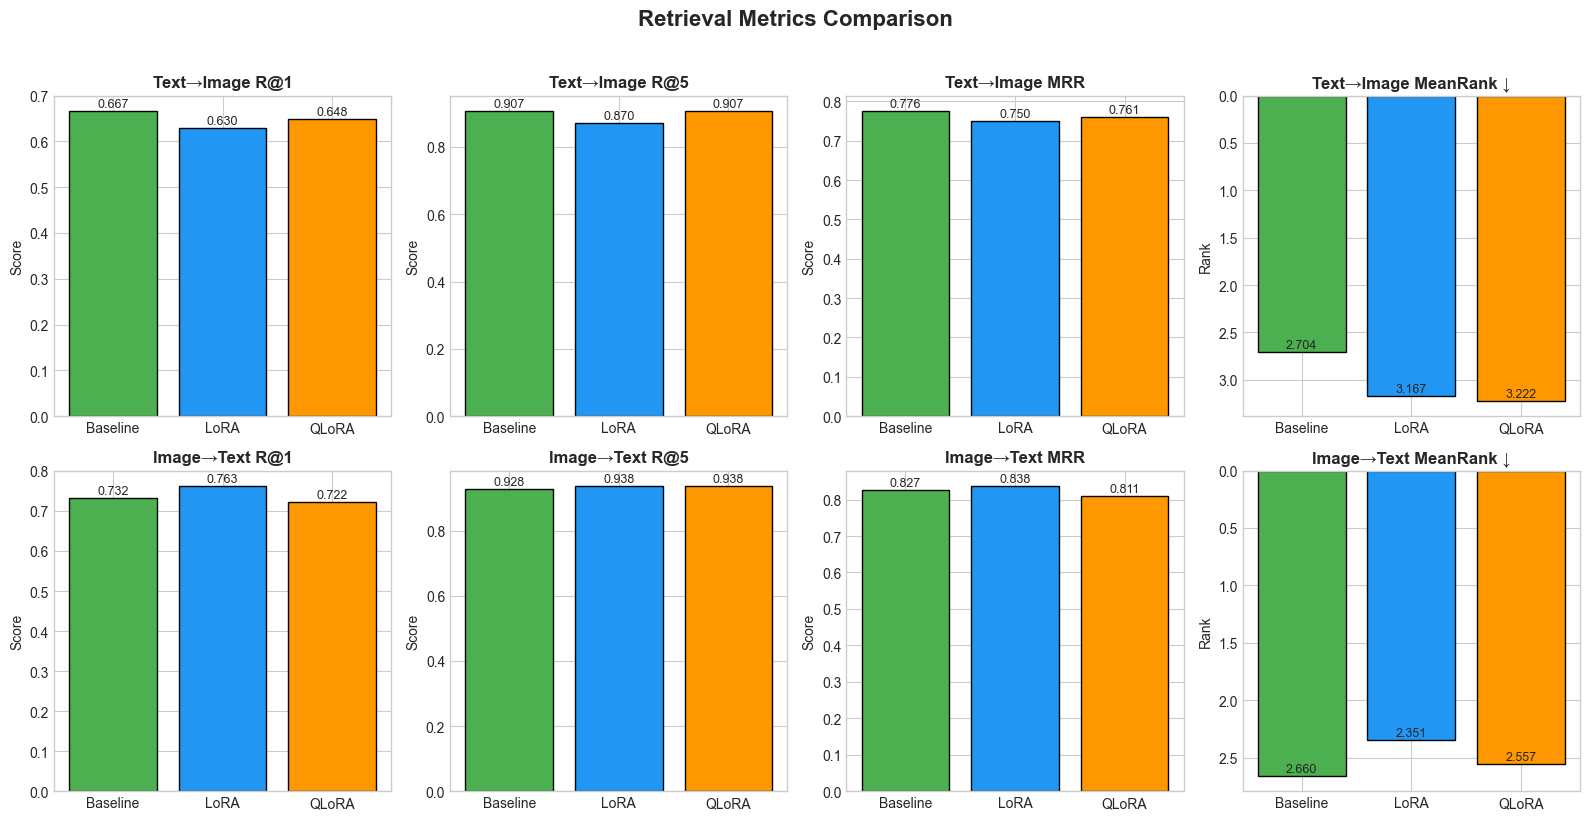

✓ Embedding generation functions defined


GPU memory cleared. Available: 3.90 GB total
Generating embeddings for 50 samples...

🔄 Loading baseline CLIP model...
✓ Baseline model loaded on cuda

🔄 Generating baseline embeddings...


Text embeddings: 100%|██████████| 50/50 [00:00<00:00, 94.67it/s]

✓ Baseline embeddings: images=(50, 512), texts=(50, 512)

🔄 Checking LoRA adapter at: experiments/lora/run_lora_20260108_211822/adapter/...



📊 Applying t-SNE to baseline embeddings...


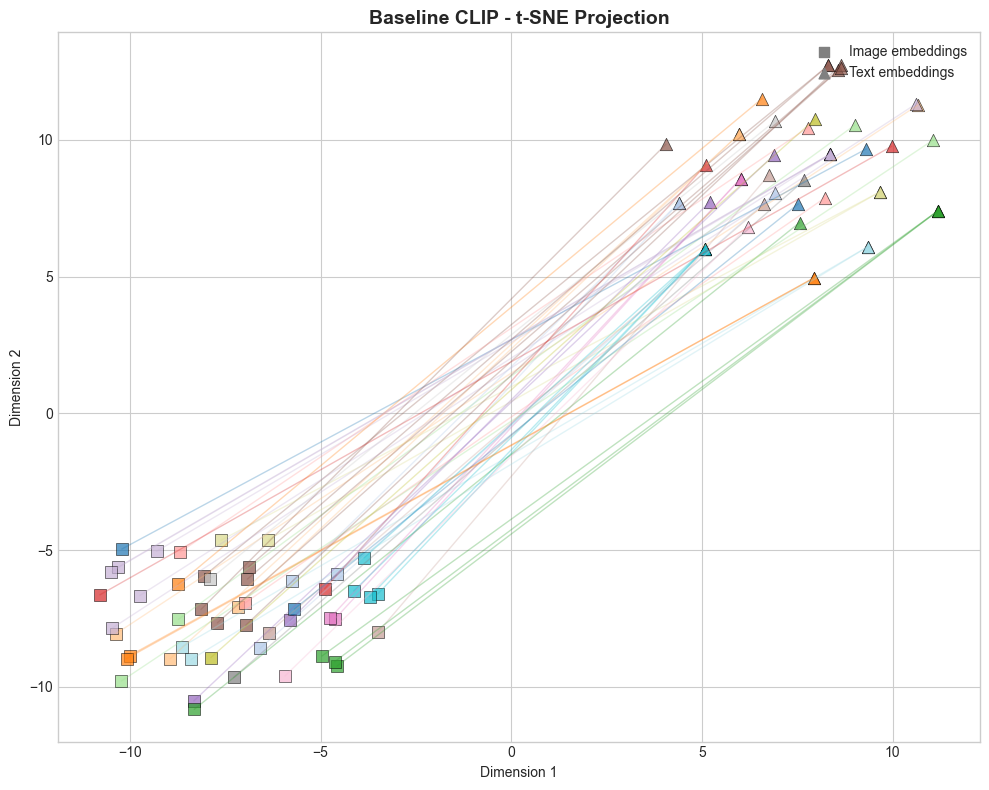


📊 Applying PCA to baseline embeddings...


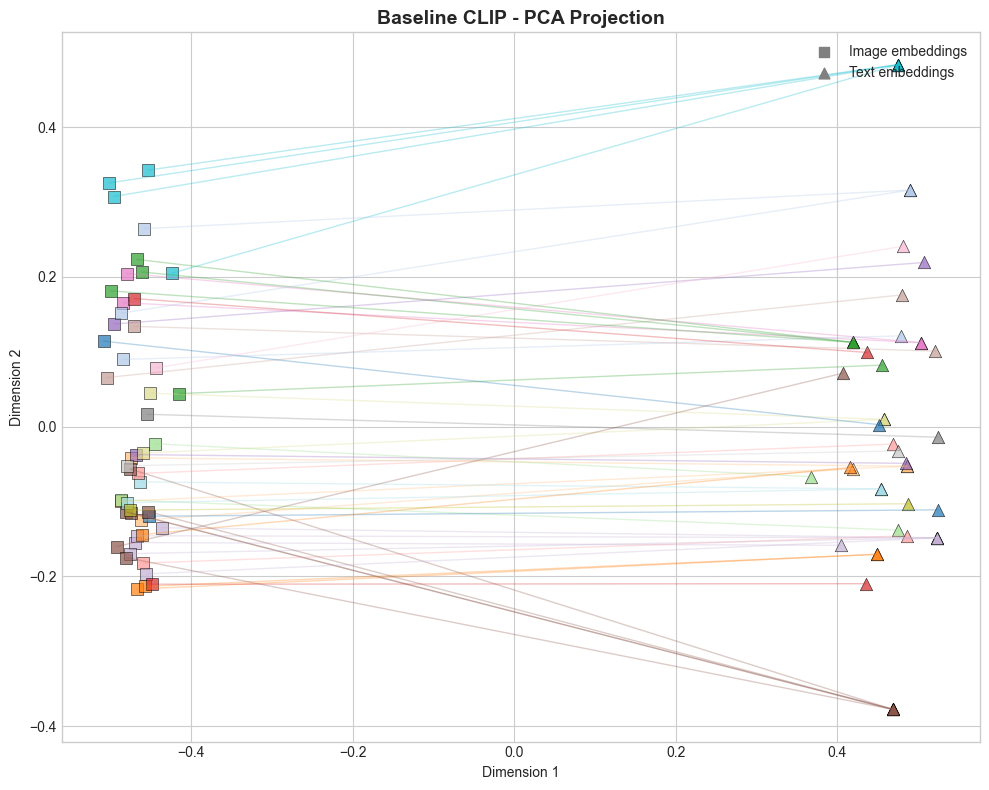


📊 Applying UMAP to baseline embeddings...


/home/didac/Desktop/upc/adsdb/adsdb-multimodal-food-data-management/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


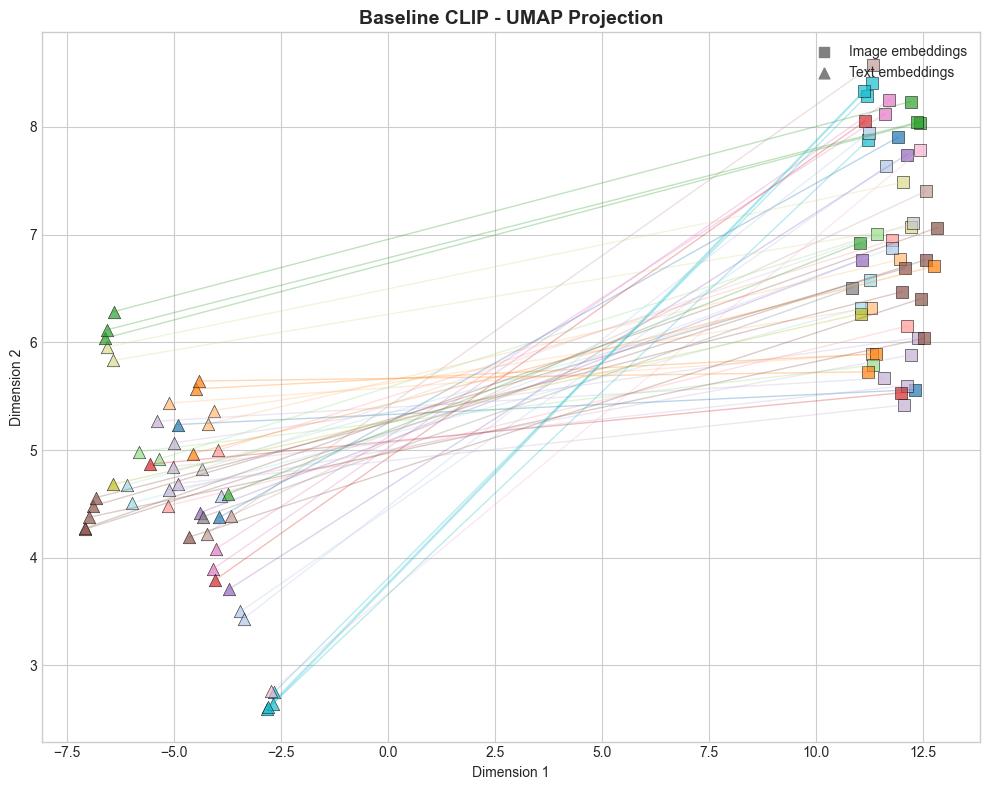

✓ Retrieval comparison functions defined



📊 SAMPLE RETRIEVAL COMPARISONS
Note: Green border = correct match, Red border = incorrect match



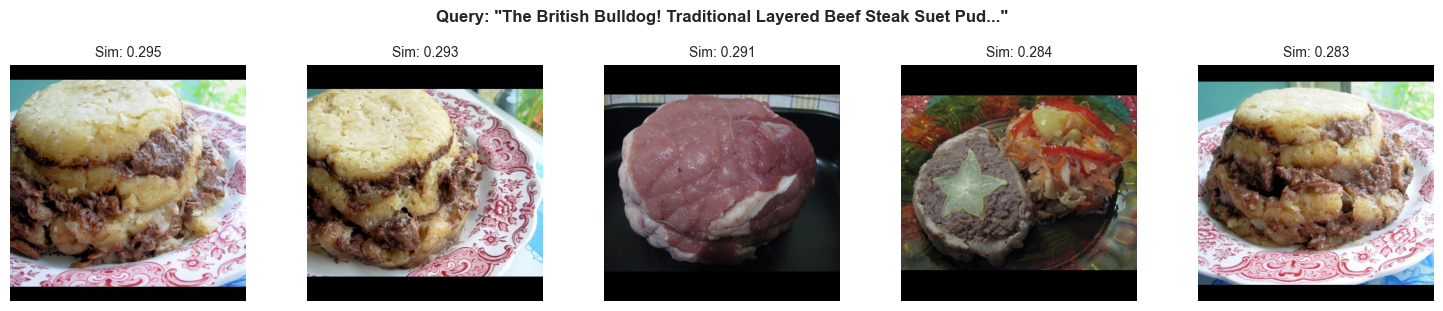

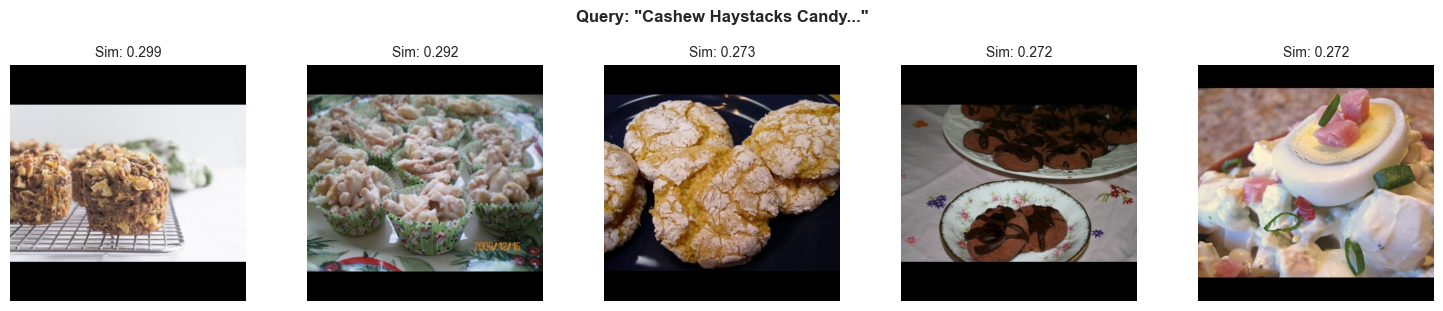

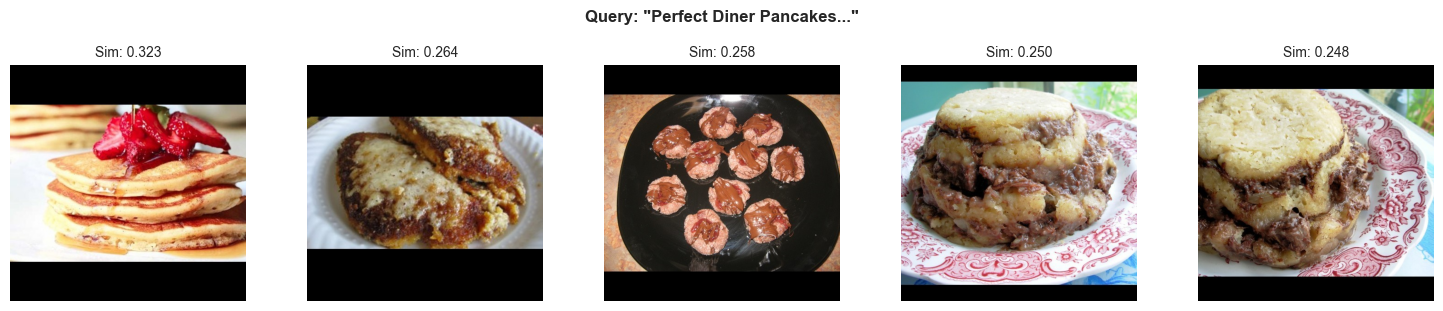

EFFICIENCY METRICS COMPARISON

📊 Training Efficiency Metrics:


,Method,Training Time (s),Peak VRAM (MB),Trainable Params,Final Loss
0,Baseline,NaN,679.704102,151277313,NaN
1,LoRA,525.183212,902.530762,983041,0.036937
2,QLoRA,690.382060,417.551270,983041,0.084274


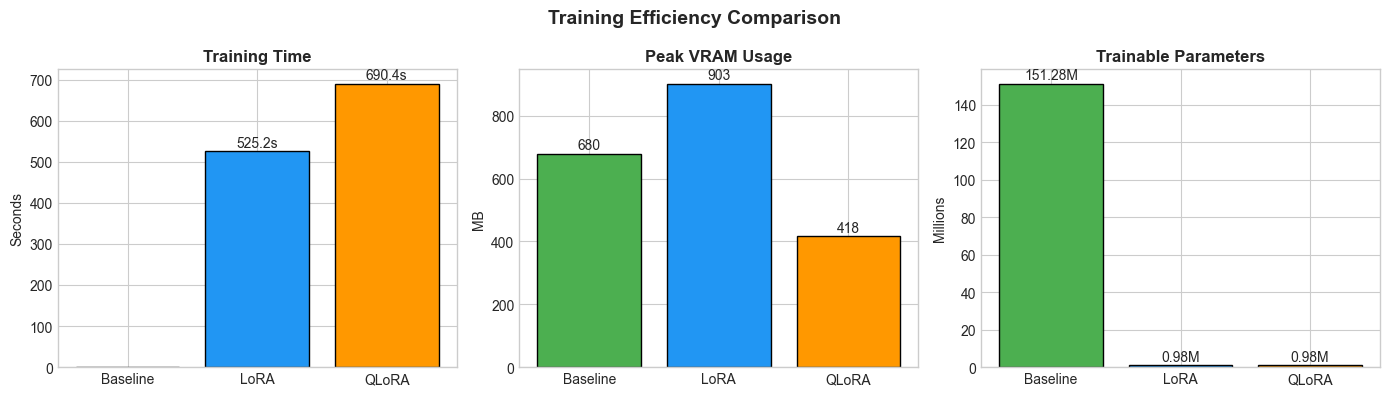

EXPERIMENT SUMMARY

📊 Key Metrics Summary:


,Method,T2I R@1,I2T R@1,MRR (avg),Training Time,Peak VRAM,Status
0,M0: Baseline,0.6667,0.7320,0.8015,N/A,679.7041015625 MB,✓
1,M1: LoRA,0.6296,0.7629,0.7942,525.1832122802734s,902.53076171875 MB,✓
2,M2: QLoRA,0.6481,0.7216,0.7858,690.3820600509644s,417.55126953125 MB,✓



HYPOTHESIS EVALUATION

🔬 H1 (LoRA): Does fine-tuning improve text↔image alignment?
   Baseline T2I R@1: 0.6667 → LoRA: 0.6296 (Δ=-0.0370)
   Baseline T2I MRR: 0.7759 → LoRA: 0.7504 (Δ=-0.0254)
   Conclusion: ✗ NOT SUPPORTED - Fine-tuning did not improve alignment

🔬 H2 (QLoRA): Does QLoRA achieve comparable performance with less memory?
   LoRA T2I R@1: 0.6296, QLoRA: 0.6481 (diff=0.0185)
   LoRA VRAM: 903 MB, QLoRA: 418 MB (savings=53.7%)
   Conclusion: ✓ SUPPORTED - QLoRA achieves comparable performance with less memory

Analysis complete!
